# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Для этого необходимо провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

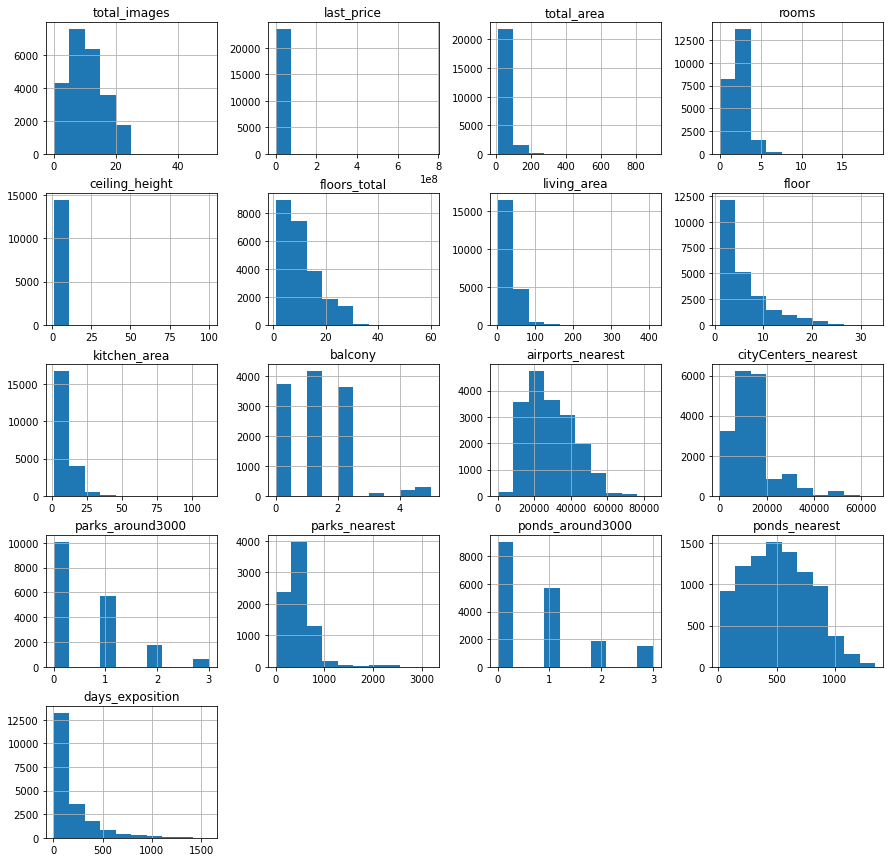

In [4]:
data.hist(figsize=(15, 15))
plt.show()

### Предобработка данных

#### Обработка пропусков
Пропущенные значения имеются в колонках *ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition*

**ceiling_height**
<br> Поскольку в одном доме должны быть одинаковые потолки на одном этаже, пропущенные значения *ceiling_height* логичнее всего заполнить по потолку квартиры на том же этаже и в том же доме. Один дом можно выделить исходя из расстояния до аэропрота.

In [5]:
data['ceiling_height'].isna().sum() # количество начальных пропусков

9195

In [6]:
a_temp = data.groupby(['airports_nearest', 'floor'])['ceiling_height'].transform('mean')
data['ceiling_height'] = data['ceiling_height'].fillna(a_temp)

data['ceiling_height'].isna().sum() # количество конечных пропусков

8314

Таким действием устранили 881 пустое значение. Осталось еще 8314. Эти пропуска заполним медианным значением

In [7]:
data['ceiling_height'].median()

2.65

In [8]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

data['ceiling_height'].isna().sum() # количество конечных пропусков

0

**floors_total** 
<br> Посмотрим в каких домах есть эти пропуски. Сгруппируем все данные по расстоянию до аэропорта и заполним недостающие данные медианным значением всех объявлений в данном доме

In [9]:
data['floors_total'].isna().sum() # количество начальных пропусков

86

In [10]:
a_temp = data.groupby('airports_nearest')['floors_total'].transform('median')
data['floors_total'] = data['floors_total'].fillna(a_temp)

data['floors_total'].isna().sum() # количество конечных пропусков

22

Осталось 22 пропуска. Заполним их значением этажа продаваемой квартиры, т.к. данный этаж точно есть в доме

In [11]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])
data['floors_total'].isna().sum()

0

**living_area** 
<br> Вначале проверим зависимость между жилой площадью и количеством комнат в квартире

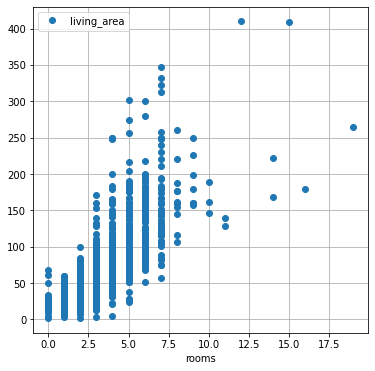

In [12]:
data.plot(x='rooms', y='living_area', style='o', grid=True, figsize=(6, 6))
plt.show()

Поскольку имеется положительная коррелляция между количеством комнат и жилой площадью, то заполним пропуски медианным значением из данных, сгруппированных по количеству комнат

In [13]:
a_temp = data.groupby('rooms')['living_area'].transform('median')
data['living_area'] = data['living_area'].fillna(a_temp)
data['living_area'].isna().sum()

0

**is_apartment** 
<br> Посмотрим, какие есть уникальные значения в данной колонке и сколько их

In [14]:
data['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

Пропущенных значений слишком много. Некорректно будет заменять их на True или False. Оставим пропуски

**kitchen_area** 
<br>Если площадь кухни не указана,то скорее всего отдельной кухни там нет (например это может быть студия или аппартаменты). Пропуски заполним нулями

In [15]:
# соотношение средней кухонной площади к средней общей площади
round(data['kitchen_area'].mean() / data['total_area'].mean(), 3) 

0.175

In [16]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*0.175)

**balcony** 
<br> Если количество балконов не указано,то скорее всего их там нет. Пропуски заполним нулями

In [17]:
data['balcony'] = data['balcony'].fillna(0)

**locality_name**
<br>Данные пропуски заполним "не определено", поскольку из имеющихся данных нельзя достоверно сказать, к какому населенному пункту относится продаваемая квартира

In [18]:
data['locality_name'].isna().sum()

49

In [19]:
data['locality_name'] = data['locality_name'].fillna('не определено')

**airports_nearest** 
<br> Заполним часть пропусков по среднему расстоянию в населенном пункте

In [20]:
data['airports_nearest'].isna().sum()

5542

In [21]:
a_temp = data.groupby('locality_name')['airports_nearest'].transform('mean')
data['airports_nearest'] = data['airports_nearest'].fillna(a_temp)
data['airports_nearest'].isna().sum()

5386

Таким образом заполнилась очень малая доля пропусков. Для оставшихся либо расстояние слишком велико, либо произошла ошибка при заполнении данных

**cityCenters_nearest**
<br> Пропуски оставим, поскольку трудно понять на каком расстоянии находится каждая квартира от центра и есть ли вообще городской центр в населенном пункте.

In [22]:
data['cityCenters_nearest'].isna().sum()

5519

**parks_around3000, parks_nearest**
<br>Определим, для скольких пропущенных значений в parks_nearest в колонке parks_around3000 стоят значения 0 и NaN.

In [23]:
data['parks_nearest'].isna().sum()

15620

In [24]:
data['parks_around3000'].isna().sum()

5518

In [25]:
len(data[(data['parks_around3000'] == 0) & (data['parks_nearest'].isna())])

10102

In [26]:
len(data[(data['parks_around3000'].isna()) & (data['parks_nearest'].isna())])

5518

исходя из этого можно сделать вывод для для всех пустых значений в parks_nearest количество парков в радиусе 3000 м либо равно 0 либо пропущено, что тоже можно приравнять к нулю. Пустые значения в parks_around3000 примем равными 0. Примем пустые значения в parks_nearest равными 4000 м (чтобы оставить численное значение - пригодится для дальнейшего анализа)

In [27]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(4000)

**ponds_around3000, ponds_nearest**
<br>Проведем аналогичную обработку для водоемов. Определим, для скольких пропущенных значений в parks_nearest в колонке parks_around3000 стоят значения 0 и NaN.

In [28]:
data['ponds_nearest'].isna().sum()

14589

In [29]:
data['ponds_around3000'].isna().sum()

5518

In [30]:
len(data[(data['ponds_around3000'] == 0) & (data['ponds_nearest'].isna())])

9071

In [31]:
len(data[(data['ponds_around3000'].isna()) & (data['ponds_nearest'].isna())])

5518

Результат такой же: пропущенные значения в ponds_around3000 означают, что водоемов в вокруг нет (можно заполнить нулем). Пропущенные значения в ponds_nearest означают, что водоемы могут быть дальше 3000 м (также примем 4000м).

In [32]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(4000)

**days_exposition**
<br>Пропуски тут означают, что либо объявление было снято в тот же день, либо до сих пор не снято. Оставим Nan

Выведем итоговую информацию по датафрейму с учетом заполненных значений

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

#### Преобразование типов данных. 

Переведем следующие столбцы по форматам, которые будут уменьшать размер датафрейма, но при этом не исказят числовые значения:
<br>uint8 (для экономии памяти) - total_images, floors_total, balcony, parks_around3000, ponds_around3000
<br>uint16 (для экономии памяти) - parks_nearest, ponds_nearest
<br>float16 (для экономии памяти) - total_area, ceiling_height, living_area, kitchen_area
<br>int - last_price

In [34]:
data[['total_images', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']] = (
    data[['total_images', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']].astype(np.uint8)
)
data[['parks_nearest', 'ponds_nearest']] = data[['parks_nearest', 'ponds_nearest']].astype(np.uint16)

data = data.astype({'last_price' : int})

data[['total_area', 'ceiling_height', 'living_area', 'kitchen_area']] = (
    data[['total_area', 'ceiling_height', 'living_area', 'kitchen_area']].astype(np.float16)
)

Поменяем формат даты в колонке first_day_exposition

In [35]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  uint8         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float16       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float16       
 6   floors_total          23699 non-null  uint8         
 7   living_area           23699 non-null  float16       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float16       
 13  balcony         

В результате экономия памяти составила 1,6 МВ (43%)

#### Поиск дубликатов (явных и неявных)
<br>В начале заменим ё на е. Затем посмотрим на уникаленые названия в датафрейме

In [37]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [38]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалево',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Будогощь',
 'городской поселок Виллози',
 'городской поселок Лесогорский',
 'городской поселок Мга',
 'городской поселок Назия',
 'городской поселок Новоселье',
 'городской поселок Павлово',
 'городской поселок Рощино',
 'городской поселок Свирьстрой',
 'городской поселок Советский',
 'городской поселок Федоровское',
 'городской поселок Янино-1',
 'деревня

Много значений, вручную проверять каждый неявный дубликат не выйдет. Есть дубликаты навроде "Мурино" и "поселок Мурино". Их можно устранить, если сделать список из 5 последних символов в каждом уникальном названии и посчитать сколько будет похожих элементов.

In [39]:
unique_names = data['locality_name'].unique()

In [40]:
last_letters = []
for i in unique_names:
    last_letters.append(i[-5:])
last_letters = Counter(last_letters)

In [41]:
sorted(last_letters.items(), key= lambda x: x[1], reverse=True)

[('олово', 13),
 ('нское', 5),
 ('й Бор', 4),
 ('горск', 4),
 ('новка', 4),
 ('итицы', 4),
 ('овицы', 4),
 ('вское', 3),
 ('строй', 3),
 ('рский', 3),
 ('ьское', 3),
 ('осово', 3),
 ('влово', 3),
 ('Ижора', 3),
 ('елево', 3),
 ('глово', 3),
 ('ьково', 3),
 ('урино', 2),
 ('дрово', 2),
 ('вский', 2),
 ('Ропша', 2),
 ('овичи', 2),
 ('илово', 2),
 ('ощино', 2),
 ('тский', 2),
 ('атово', 2),
 ('Рахья', 2),
 ('селье', 2),
 ('лпаны', 2),
 ('адога', 2),
 ('ябово', 2),
 ('уницы', 2),
 ('илицы', 2),
 ('ещево', 2),
 ('итино', 2),
 ('жский', 2),
 ('ьский', 2),
 ('Назия', 2),
 ('юбань', 2),
 ('орово', 2),
 ('долье', 2),
 ('Горка', 2),
 ('ельки', 2),
 ('омово', 2),
 ('есное', 2),
 ('рбург', 1),
 ('ушары', 1),
 ('ино-1', 1),
 ('носов', 1),
 ('ергоф', 1),
 ('ушкин', 1),
 ('мунар', 1),
 ('лпино', 1),
 ('тчина', 1),
 ('ыборг', 1),
 ('штадт', 1),
 ('ровск', 1),
 ('ткино', 1),
 ('бяжье', 1),
 ('дцово', 1),
 ('ловск', 1),
 ('ложск', 1),
 ('олхов', 1),
 ('исепп', 1),
 ('зерск', 1),
 ('орецк', 1),
 ('ттузи'

Проверим каждый элемент списка unique_names, который заканчивается одинаково. Для этого напишем функцию вывода всех названий с определенной подстрокой

In [42]:
def find_name(string):
    lst = []
    for i in unique_names:
        if string in i:
            lst.append(i)
    return lst

In [43]:
find_name('олово')

['поселок Парголово',
 'Сертолово',
 'деревня Пикколово',
 'деревня Лесколово',
 'поселок Терволово',
 'деревня Лаголово',
 'деревня Мистолово',
 'деревня Кузьмолово',
 'деревня Гарболово',
 'деревня Старое Хинколово',
 'поселок Гарболово',
 'деревня Рапполово',
 'деревня Лупполово']

Обнаружились дубликаты: 'деревня Гарболово' и 'поселок Гарболово'. Правильно будет 'деревня Гарболово'. 
Проверив остальные названия из колонки locality_name на повторяющиеся подстроки из last_letters обнаружим следующие дубликаты (в итоговом датафрейме оставим вторые варианты):

1. 'поселок при железнодорожной станции Приветнинское' : 'поселок станции Приветнинское'
2. 'поселок городского типа Лесогорский' : 'городской поселок Лесогорский'
3. 'деревня Зимитицы' : 'поселок Зимитицы'
4. 'деревня Рабитицы' : 'поселок Рабитицы'
5. 'село Никольское' : 'Никольское'
6. 'поселок городского типа Большая Ижора' : 'городской поселок Большая Ижора'
7. 'городской поселок Федоровское' : 'деревня Федоровское'
8. 'деревня Щеглово' : 'поселок Щеглово'
9. 'деревня Кудрово' : 'Кудрово'
10. 'поселок Любань' : 'Любань'
11. 'поселок Мурино' : 'Мурино',
12. 'поселок городского типа Назия' : 'городской поселок Назия'
13. 'поселок городского типа Рощино' : 'городской поселок Рощино'
14. 'поселок городского типа Советский' : 'городской поселок Советский'
15. 'деревня Калитино' : 'поселок Калитино'
16. 'коттеджный поселок Лесное' : 'поселок Лесное',
17. 'поселок станции Громово' : 'поселок Громово'
18. 'поселок городского типа Рябово' : 'поселок Рябово'
19. 'садовое товарищество Приладожский' : 'поселок городского типа Приладожский'
20. 'садовое товарищество Рахья' : 'поселок городского типа Рахья'
21. 'поселок при железнодорожной станции Вещево' : 'поселок станции Вещево'
22. 'поселок городского типа Мга': 'городской поселок Мга'
23. 'городской поселок Павлово' : 'село Павлово'
24. 'поселок городского типа Павлово' : 'село Павлово'


In [44]:
data['locality_name'] = data['locality_name'].replace({
    'поселок Гарболово': 'деревня Гарболово',
    'поселок при железнодорожной станции Приветнинское': 'поселок станции Приветнинское', 
    'поселок городского типа Лесогорский': 'городской поселок Лесогорский', 
    'деревня Зимитицы' : 'поселок Зимитицы',
    'деревня Рабитицы' : 'поселок Рабитицы',
    'село Никольское' : 'Никольское',
    'поселок городского типа Большая Ижора' : 'городской поселок Большая Ижора',
    'городской поселок Федоровское' : 'деревня Федоровское',
    'деревня Щеглово' : 'поселок Щеглово',
    'деревня Кудрово' : 'Кудрово', 
    'поселок Любань' : 'Любань', 
    'поселок Мурино' : 'Мурино', 
    'поселок городского типа Назия' : 'городской поселок Назия', 
    'поселок городского типа Рощино' : 'городской поселок Рощино', 
    'поселок городского типа Советский' : 'городской поселок Советский', 
    'деревня Калитино' : 'поселок Калитино', 
    'коттеджный поселок Лесное' : 'поселок Лесное', 
    'поселок станции Громово' : 'поселок Громово', 
    'поселок городского типа Рябово' : 'поселок Рябово', 
    'садовое товарищество Приладожский' : 'поселок городского типа Приладожский', 
    'садовое товарищество Рахья' : 'поселок городского типа Рахья', 
    'поселок при железнодорожной станции Вещево' : 'поселок станции Вещево',
    'поселок городского типа Мга': 'городской поселок Мга',
    'городской поселок Павлово' : 'село Павлово',
    'поселок городского типа Павлово' : 'село Павлово'
})

Еще раз пробежимся по списку уникальных значений для проверки (похожие по последним буквам слова будут рядом)

In [45]:
sorted(data['locality_name'].unique(), key= lambda x: x[-1::-1])

['городской поселок Янино-1',
 'поселок Тесово-4',
 'деревня Пчева',
 'деревня Борисова Грива',
 'поселок городского типа имени Морозова',
 'поселок городского типа имени Свердлова',
 'городской поселок Мга',
 'Новая Ладога',
 'село Старая Ладога',
 'Луга',
 'поселок Усть-Луга',
 'поселок Победа',
 'поселок Суйда',
 'деревня Суоранда',
 'деревня Большая Вруда',
 'поселок Пчевжа',
 'деревня Большая Пустомержа',
 'поселок Алексеевка',
 'деревня Заневка',
 'деревня Снегиревка',
 'поселок Мыза-Ивановка',
 'поселок Романовка',
 'деревня Малая Романовка',
 'поселок городского типа Ульяновка',
 'поселок городского типа Дубровка',
 'деревня Камышовка',
 'поселок станции Лужайка',
 'деревня Глинка',
 'деревня Лопухинка',
 'деревня Пустынка',
 'поселок Петро-Славянка',
 'поселок городского типа Дружная Горка',
 'поселок Форт Красная Горка',
 'деревня Белогорка',
 'деревня Выскатка',
 'деревня Пижма',
 'деревня Нурма',
 'поселок Тельмана',
 'поселок Красная Долина',
 'Гатчина',
 'поселок Стрельна

In [46]:
len(data.drop_duplicates())

23699

Явных дубликатов нет

#### Поиск аномалий 
Аномальными значениями примем те, которые неестесственны и противоречат СНиПам, ГОСТам, СП.

In [47]:
for i in ['total_images', 'last_price', 'total_area', 'rooms', 
          'ceiling_height', 'floors_total', 'living_area', 'floor', 
          'kitchen_area', 'balcony']:
        print(i, data[i].min(), data[i].max())

total_images 0 50
last_price 12190 763000000
total_area 12.0 900.0
rooms 0 19
ceiling_height 1.0 100.0
floors_total 1 60
living_area 2.0 409.8
floor 1 33
kitchen_area 1.3 112.0
balcony 0 5


Примем следующие граничные условия:

1. Цена: до 100 млн.руб,
2. Количество комнат: от 1 комнаты,
2. Высота потолка: 2 - 10 м
3. Жилая площадь: от 6 м2,
4. Площадь кухни: до 30 м2.

Создадим колонку в датафрейме с указанием на наличие аномальных значений в объявлении. True - есть аномалия, False - нет. Если аномальные объявления в будущем не пригодятся то просто удалим их

In [48]:
data['anomaly'] = (
    (data['last_price'] > 100000000) | (data['rooms'] < 1) | (data['ceiling_height'] < 2) | 
    (data['ceiling_height'] > 10) | (data['living_area'] < 6) | (data['kitchen_area'] > 30)
)

In [49]:
data['anomaly'].value_counts()

False    23090
True       609
Name: anomaly, dtype: int64

#### Добавление в таблицу новых столбцов

In [50]:
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,anomaly
0,20,13000000,108.00000,2019-03-07,3,2.699219,16,51.00000,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482,2,755,NaN,False
1,7,3350000,40.40625,2018-12-04,1,2.650391,11,18.59375,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,4000,0,4000,81.0,False


In [51]:
data['sqr_cost'] = round((data['last_price'] / data['total_area']), 2)  # столбец с ценой кв. метра
data['week_day'] = data['first_day_exposition'].dt.weekday       # столбец с днем недели объявления: 0 - Пн, 1- Вт и т.д.
data['month'] = data['first_day_exposition'].dt.month            # столбец с месяцем объявления
data['year'] = data['first_day_exposition'].dt.year              # столбец с годом объявления

In [52]:
def type_floor(a):                                               # функция для определения типа этажа
    if a['floor'] == 1:
        return 'первый'
    elif a['floor'] == a['floors_total']:
        return 'последний'
    else: return 'другой'

In [53]:
data['type_floor'] = data.apply(type_floor, axis=1)              # столбец с типом этажа
data['cityCenters_km'] = data['cityCenters_nearest'] / 1000      # столбец с расстоянием до центра в км

### Исследовательский анализ данных

#### Общая площадь, жилая площадь и площадь кухни
Посмотрим на распределение значений площадей по количеству объявлений, в которых они встречаются с учетом ранее выявленных аномалий.

In [54]:
data = data.query('anomaly == False')  #  данные без аномалий

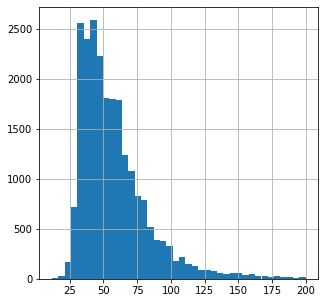

In [55]:
data['total_area'].hist(bins=40, range=(12, 200), figsize=(5, 5))
plt.show()

In [56]:
len(data[data['total_area'] > 170])*100/23699

0.91565044938605

Распределение квартир по площади имеет положительную ассиметрию. Квартир с площадью более 170 кв.м около 1%.

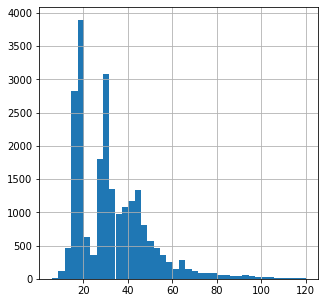

In [57]:
data['living_area'].hist(bins=40, range=(6, 120), figsize=(5, 5))
plt.show()

In [58]:
len(data[data['living_area'] > 110])*100/23699

0.8059411789526985

In [59]:
len(data[((data['living_area'] >= 14.3) & (data['living_area'] <= 20)) | 
         ((data['living_area'] >= 25.7) & (data['living_area'] <= 31.4))])*100/23699

48.626524325920926

Распределение мультимодальное. Квартиры со значением жилой площади в диапазонах 14,3-20 и 25,7-31,4 кв.м составляют 49% от всех предложений.
Квартиры с жилой площадью более 110 кв.м составляют мене 1%.

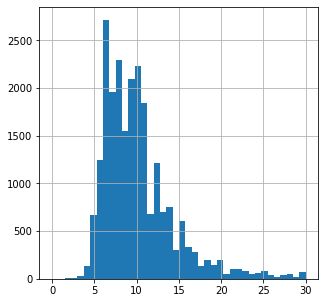

In [60]:
data['kitchen_area'].hist(bins=40, range=(0, 30), figsize=(5, 5))
plt.show()

In [61]:
len(data[data['kitchen_area'] > 25])*100/23699

1.071775180387358

In [62]:
len(data[(data['kitchen_area'] >= 5) & (data['kitchen_area'] <= 12)])*100/23699

75.30697497784716

Распределение имеет положительную ассиметрию с большим количеством кухонь с нулевой площадью. Скорее всего это связано с тем, что в квартирах с типом студия и аппартаменты кухни не учитываются. В основном в данных представлены квартиры с площадью кухни от 5 до 12 кв. м (75%). Квартир с площадью кухни более 25 кв. м примерно 1%.

#### Цена объекта

In [63]:
data['last_price'] = data['last_price'] / 1000000    # Переведем значения столбца last_price в млн.руб.

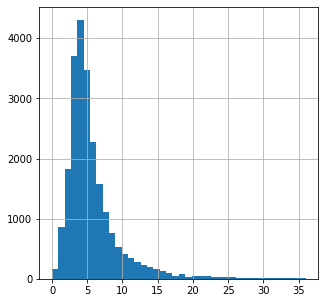

In [64]:
data['last_price'].hist(bins=40, range=(0, 36), figsize=(5, 5))
plt.show()

In [65]:
len(data[data['last_price'] > 29])*100/23699

0.9114308620616903

In [66]:
len(data[(data['last_price'] >= 0) & (data['last_price'] <= 8)])*100/23699

81.29878897843791

Распределение цены также имеет положительную ассиметрию, что косвенно указывает на наличие корреляции между площадью и ценой. 1% всех квартир в данных имеют стоимость более 29 млн.руб. 81% всех квартир стоят до 8 млн. руб.

#### Количество комнат

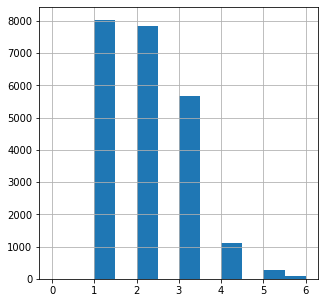

In [67]:
data['rooms'].hist(bins=12, range=(0, 6), figsize=(5, 5))
plt.show()

In [68]:
display(len(data[(data['rooms'] >= 1) & (data['rooms'] <= 3)])*100/23699)
display(len(data[(data['rooms'] >= 1) & (data['rooms'] <= 6)])*100/23699)

90.96164395122157

97.15177855605722

Как можно видеть, 91% всех квартир имеют от 1 до 3 комнат и 97% с комнатами от 1 до 6.

#### Высота потолков

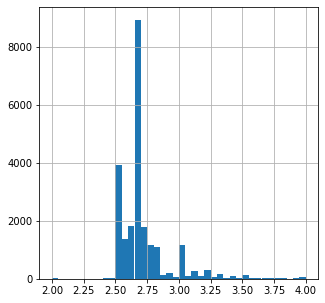

In [69]:
data['ceiling_height'].hist(bins=40, range=(2, 4), figsize=(5, 5))
plt.show()

In [70]:
len(data[(data['ceiling_height'] >= 2.5) & (data['ceiling_height'] <= 3)])*100/23699

90.90256972868053

91% всех квартир имеют высоту потолков от 2,5 до 3 метров.

#### Позиция этажа и количество этажей в доме

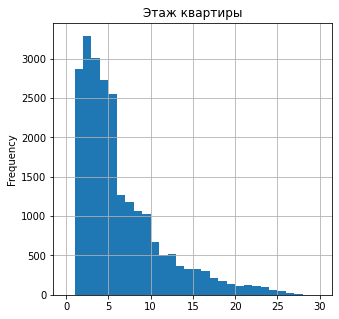

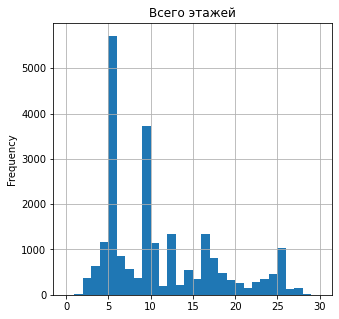

In [71]:
data['floor'].plot(kind='hist',bins=30, range=(0, 30), figsize=(5, 5), title='Этаж квартиры', grid=True)
plt.show()
data['floors_total'].plot(kind='hist',bins=30, range=(0, 30), figsize=(5, 5), title='Всего этажей', grid=True)
plt.show()

In [72]:
len(data[(data['floor'] >= 1) & (data['floor'] <= 4)])*100/23699

50.19199122325836

In [73]:
len(data[(data['floors_total'] >= 1) & (data['floors_total'] <= 27)])*100/23699

97.22351154057134

In [74]:
len(data[(data['floors_total'] == 5) | (data['floors_total'] == 9)])*100/23699

39.832904341955356

**Тип этажа**

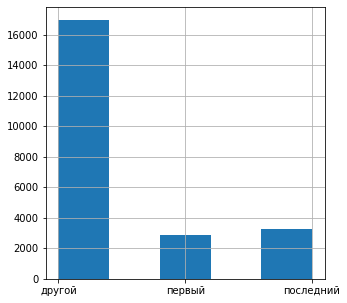

In [75]:
data['type_floor'].hist(bins=5, figsize=(5, 5))
plt.show()

In [76]:
len(data[(data['type_floor'] == 'другой')])*100/23699

71.55576184649141

Как видно, половина всех квартир на продажу находится с 1 по 4 этаж. Это связано с большим количеством объявлений о продаже квартиры в мелких населенных пунктах, где многоэтажное строительство не развито. Только 28% квартир на продажу находятся на первом или последнем этаже. Квартиры начиная с 26 этажа встречаются редко (менее 3% всех объявлений). 
<br>40% всех квартир располагаются либо в 5тиэтажных (хрущевках), либо в 9тиэтажных домах старой застройки.

#### Расстояние до центра города и ближайшего парка

In [77]:
for i in ['cityCenters_nearest', 'parks_nearest']:
        print(i, data[i].min(), data[i].max())

cityCenters_nearest 181.0 65968.0
parks_nearest 1 4000


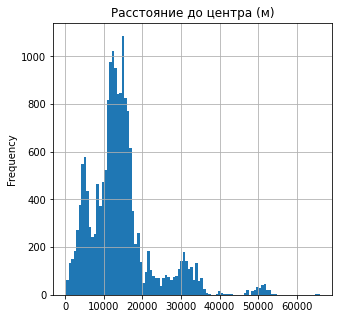

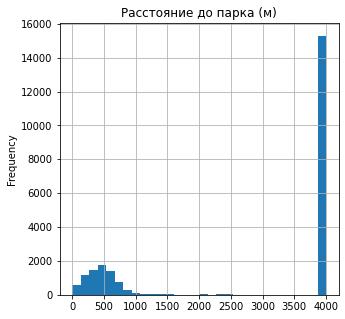

In [78]:
data['cityCenters_nearest'].plot(kind='hist',bins=100, figsize=(5, 5), title='Расстояние до центра (м)', grid=True)
plt.show()
data['parks_nearest'].plot(kind='hist',bins=30, figsize=(5, 5), title='Расстояние до парка (м)', grid=True)
plt.show()

In [79]:
display(len(data[data['cityCenters_nearest'] <= 15000])*100/18303)
display(len(data[data['parks_nearest'] == 4000])*100/23699)
display(len(data[data['parks_nearest'] <= 1000])*100/23699)

62.55805059279899

64.47951390354024

31.423266804506518

Видно, что расстояния до городского центра доходят до 66 км. Должно быть во многих населенных пунктах расстояние указано до городского центра, находящегося в другом населеном пункте. 63% всех квартир находится в радиусе 15 км от городского центра. 
<br>64% всех квартир на продажу не имеют парков в пределах 3 км и для 31% квартир парки находятся в пределах 1 км.

#### Скорость продажи квартир

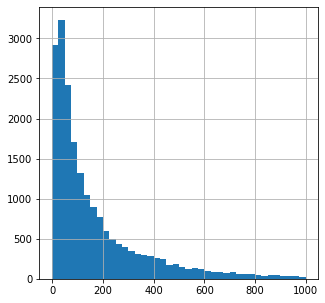

In [80]:
data['days_exposition'].hist(bins=40, range=(0, 1000), figsize=(5, 5))
plt.show()

In [81]:
display(len(data[data['days_exposition'] > 730])*100/20518)
display(len(data[data['days_exposition'] < 365])*100/20518)
display(len(data[data['days_exposition'] < 122])*100/20518)

3.4993664099814796

83.1903694317185

55.911882249731946

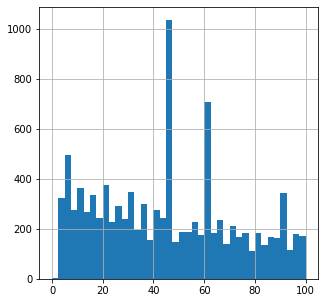

In [82]:
data['days_exposition'].hist(bins=40, range=(0, 100), figsize=(5, 5))
plt.show()

In [83]:
data['days_exposition'].describe()

count    20025.000000
mean       179.795256
std        218.049900
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

Было продано только 3% квартир с объявлениями давностью более 2х лет. 83% продаж приходится на первый год размещения обявления. 56% всех квартир из данных были проданы спустя 4 месяца (122 дня) после публикации объявления.
Исходя из этого можно сделать вывод, что не имеет смысла держать обявление дольше года.
<br>Среднее время продаж составляет 180 дней. Медианное время - 95 дней.

#### Факторы, влияющие на стоимость

Для построения графиков выберем диапазоны, включающие 99% значений. Рассчитаем коэффициенты корреляции.

**Площади помещений**

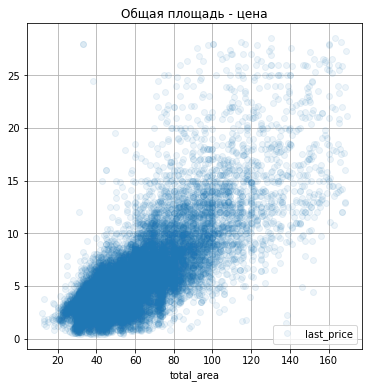

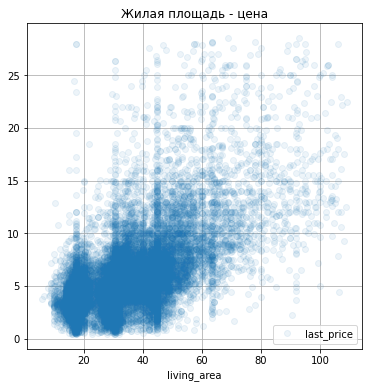

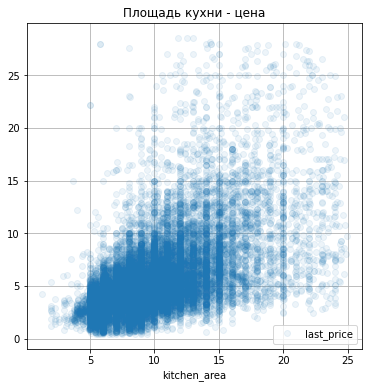

In [84]:
data.query('(total_area < 170) & (last_price < 29)').plot(
    x='total_area', y='last_price', style='o', grid=True, figsize=(6, 6), alpha=0.08, title='Общая площадь - цена')
plt.show()
data.query('(living_area < 110) & (last_price < 29)').plot(
    x='living_area', y='last_price', style='o', grid=True, figsize=(6, 6), alpha=0.08, title='Жилая площадь - цена')
plt.show()
data.query('(kitchen_area < 25) & (last_price < 29)').plot(
    x='kitchen_area', y='last_price', style='o', grid=True, figsize=(6, 6), alpha=0.08, title='Площадь кухни - цена')
plt.show()

In [85]:
data[['last_price', 'total_area', 'living_area', 'kitchen_area']].corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.748964,0.653733,0.538509
total_area,0.748964,1.000000,0.927588,0.587567
living_area,0.653733,0.927588,1.000000,0.400098
kitchen_area,0.538509,0.587567,0.400098,1.000000


Из графиков и расчета коэффициента Пирсона видно, что наибольшая корреляция (кф.корр. = 0,75) наблюдается между стоимостью и общей площадью.

**Количество комнат**

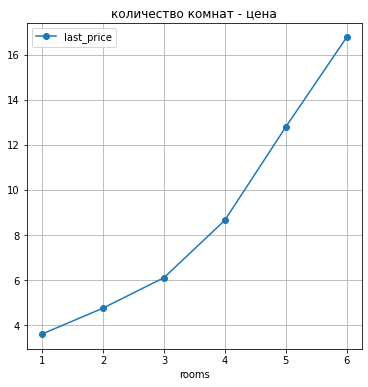

In [86]:
data.query('rooms <= 6').pivot_table(index='rooms', values='last_price', aggfunc='median').plot(
    y='last_price', style='o-', grid=True, figsize=(6, 6), title='количество комнат - цена')
plt.show()

Имеется положительная корреляция между количеством комнат и ценой квартиры

**Тип этажа**

In [87]:
data.groupby('type_floor')['last_price'].agg('median')

type_floor
другой       4.80
первый       3.90
последний    4.28
Name: last_price, dtype: float64

Видно, что в основном цена для первого этажа ниже, чем для последнего и тем более для прочих этажей

**Дата размещения объявления**

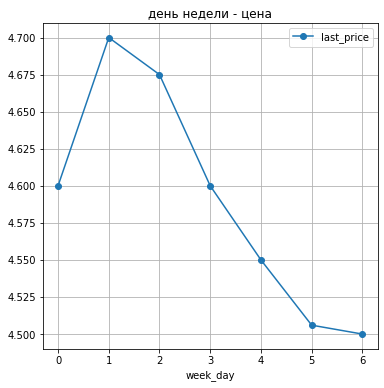

week_day
0    4.600
1    4.700
2    4.675
3    4.600
4    4.550
5    4.506
6    4.500
Name: last_price, dtype: float64

In [88]:
data.pivot_table(index='week_day', values='last_price', aggfunc='median').plot(
    y='last_price', style='o-', grid=True, figsize=(6, 6), title='день недели - цена')
plt.show()
data.groupby('week_day')['last_price'].agg('median')

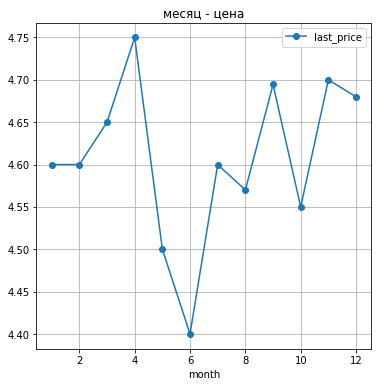

In [89]:
data.pivot_table(index='month', values='last_price', aggfunc='median').plot(
    y='last_price', style='o-', grid=True, figsize=(6, 6), title='месяц - цена')
plt.show()

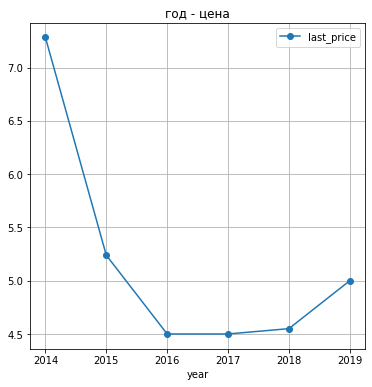

In [90]:
data.pivot_table(index='year', values='last_price', aggfunc='median').plot(
    y='last_price', style='o-', grid=True, figsize=(6, 6), title='год - цена')
plt.show()

In [91]:
data.groupby('year')['last_price'].count()

year
2014     126
2015    1149
2016    2738
2017    7945
2018    8329
2019    2803
Name: last_price, dtype: int64

Медианная цена на квартиры во вторник на 200 тыс.руб выше, чем в воскресенье. Но вцелом нет корреляции между ценой квартиры и датой размещения объявления. 
<br> Как видно, в 2014 году очень мало объявлений и самая высокая цена квартир. А в 2017 и 2018 годах наибольшее предложение квартир и при этом наименьшая цена. Скорее всего большое предложение квартир снижает цену на них.

#### Средняя цена 1 кв.м. в разных населенных пунктах

In [92]:
# выделим 10 наиболее распространенных городов из исходного датафрейма в новый датафрейм
top_cities = data.groupby('locality_name')['total_area'].count().sort_values(ascending=False).head(10).reset_index()

In [93]:
top_cities = top_cities.rename(columns={'total_area' : 'flats'})  # Переименуем колонку с количеством объявлений
top_cities

,locality_name,flats
0,Санкт-Петербург,15242
1,Мурино,560
2,Кудрово,449
3,поселок Шушары,434
4,Всеволожск,391
5,Пушкин,360
6,Колпино,337
7,поселок Парголово,322
8,Гатчина,305
9,Выборг,235


In [94]:
# создадим датафрем со средними значениями стоимости кв. метра в 10 самых популярных городах
top_cities_sqr = (data.loc[data['locality_name'].isin(top_cities['locality_name'])]
                  .groupby('locality_name')['sqr_cost'].mean().reset_index())

In [95]:
top_cities_sqr['sqr_cost'] = top_cities_sqr['sqr_cost'].astype(int)  # переведем в int(для удобства)

In [96]:
top_cities = top_cities.merge(top_cities_sqr, how='left').sort_values(by='sqr_cost') # соединим два датафрейма, отсортируем

In [97]:
top_cities

,locality_name,flats,sqr_cost
9,Выборг,235,57841
4,Всеволожск,391,68576
8,Гатчина,305,68687
6,Колпино,337,75333
3,поселок Шушары,434,78481
1,Мурино,560,85478
7,поселок Парголово,322,90449
2,Кудрово,449,95207
5,Пушкин,360,102701
0,Санкт-Петербург,15242,112281


В десятке самых популярных городов Ленинградской области самые дорогие квартиры в Санкт-Петербурге (112 281 руб/кв.м), а самые дешевые в Выборге (57 841 руб/кв.м).

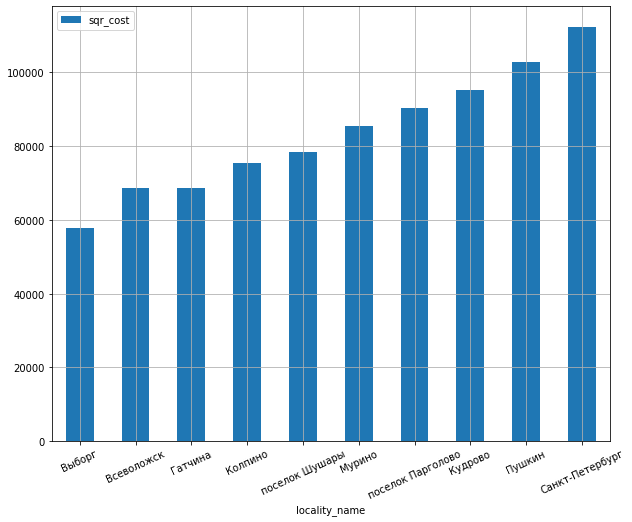

In [98]:
top_cities.plot(kind='bar', x='locality_name', y='sqr_cost', grid=True, figsize=(10, 8))
plt.xticks(rotation = 25)
plt.show()

#### Стоимость квартиры в зависимости от расстояния до центра в Санкт-Петербурге

In [99]:
flat_cost = data.dropna(subset=['cityCenters_km']) # Удалим данные с расстоянием до центра = Nan. Эти данные уже не нужны
flat_cost = flat_cost.astype({'cityCenters_km' : int})

In [100]:
flat_cost.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,anomaly,sqr_cost,week_day,month,year,type_floor,cityCenters_km
0,20,13.00,108.00000,2019-03-07,3,2.699219,16,51.00000,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482,2,755,NaN,False,120370.37,3,3,2019,другой,16
1,7,3.35,40.40625,2018-12-04,1,2.650391,11,18.59375,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,4000,0,4000,81.0,False,82907.97,1,12,2018,первый,18


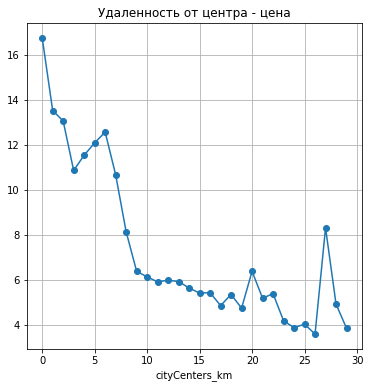

In [101]:
flat_cost.loc[flat_cost['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_km')['last_price'].mean().plot(
    style='o-', grid=True, figsize=(6, 6), title='Удаленность от центра - цена')
plt.show()

Как видно, при удалении от центра цены на квартиры снижаются. Особенно сильно снижение от 0 до 9 км от центра. На удалении более 29 км на продажу нет ни одной квартиры (с учетом исключения ранее выявленных аномалий и замены пропусков)

### Общий вывод

**Общие сведения о данных**
<br>В полученных данных имеется информация о 23699 объявлениях о продаже квартир в Ленинградской области. Данные представлены неполные: пропущенные значения имеются в колонках *ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition*

**Обработка пропусков**
<br>Пропущенные значения в колонках ceiling_height, floors_total, living_area, airports_nearest, cityCenters_nearest по возможности заполнялись по аналогичным объектам, находящимся в том же доме. Прочие были заполнены по среднему либо медианному значению или оставлены незаполненными.
<br>Колонка *is_apartment* была оставлена незаполненной по причине того, что пропущенных значений слишком много (88%). Данный столбец в дальнейшем анализе не использовался, поэтому остался неизменным.
<br>Колонка *kitchen_area* была заполнена с учетом среднего отношения: площадь кухни/общая площадь, а *balcony* нулями. Отсутствие значения в *kitchen_area* скорее всего означает, что отдельной кухни нет (студия или аппартаменты). Отсутствие значения в *balcony* означает, что балкона в квартире нет.
<br>Пропуски в *locality_name* были оставлены по причине невозможности заполнения данной колонки корректно. 
<br>Пустые значения в *parks_around3000 и ponds_around3000* примем равными 0, а в *parks_nearest и ponds_nearest* примем равными 4000 м.
<br>В итоге незаполненные значения остались в столбцах: *is_apartment, airports_nearest, cityCenters_nearest и days_exposition*. Пропуски в *days_exposition* означают, что либо объявление было снято в тот же день, либо до сих пор не снято.

**Обработка типов данных**
<br>Для экономии памяти и удобства работы следующие колонки переведены в форматы:
uint8 - total_images, floors_total, balcony, parks_around3000, ponds_around3000;
uint16 - parks_nearest, ponds_nearest;
float16 - total_area, ceiling_height, living_area, kitchen_area;
int - last_price.
<br>Даты в колонке first_day_exposition переведены в более читаемый вид.
<br>В результате выполненных действий сокращение памяти датафрейма составило 1,6 МВ (43%)

**Поиск дубликатов**
<br>Была выполнена замена буквы "ё" на "е". 
Неявные дубликаты, например "Мурино" и "поселок Мурино" были обнаружены и устранены. Всего оказалось 24 неявных дубликата.
Явных дубликатов обнаружено не было.

**Поиск аномалий**
<br>Аномальными значениями примем те, которые неестесственны и противоречат СНиПам, ГОСТам, СП. Для этого примем следующие граничные условия:
1. Цена: до 100 млн.руб,
2. Количество комнат: от 1 комнаты,
3. Высота потолка: 2 - 10 м,
4. Жилая площадь: от 6 м2,
5. Площадь кухни: до 30 м2.
<br>Под данные критерии не подходят 572 квартиры (2,4%).

<br>Для дальнейшего анализа в датафрейм были добавлены дополнительные столбцы:
1. цена одного квадратного метра;
2. день недели публикации объявления (0 — понедельник, 1 — вторник и т.д.);
3. месяц публикации объявления;
4. год публикации объявления;
5. тип этажа квартиры;
6. расстояние до центра города в километрах. 

**Исследовательский анализ данных**
<br>В результате выполненного исследовательского анализа данных были сделаны следующие выводы:
1. Распределение квартир по площади имеет положительную ассиметрию. Квартир с площадью более 170 кв.м около 1%.
2. Распределение квартир по жилой площади - мультимодальное. Квартиры со значением в диапазонах 14,3-20 и 25,7-31,4 кв. м составляют 49% от всех предложений. Квартиры с жилой площадью более 110 кв. м составляют мене 1%.
3. Распределение квартир по площади кухни также имеет положительную ассиметрию с большим количеством пропусков. Скорее всего это связано с тем, что в квартирах с типом студия и аппартаменты кухни не учитываются. В основном в данных представлены квартиры с площадью кухни от 5 до 12 кв. м (75%). Квартир с площадью кухни более 25 кв. м менее 1%.
4. Распределение цены также имеет положительную ассиметрию, что косвенно указывает на наличие корреляции между площадью и ценой. 1% всех квартир в данных имеют стоимость более 29 млн.руб. 81% всех квартир стоят до 8 млн. руб.
5. В данных 91% всех квартир имеют от 1 до 3 комнат и 97% с комнатами от 1 до 6.
6. 91% всех квартир имеют высоту потолков от 2,5 до 3 метров.
7. Половина всех квартир на продажу находится с 1 по 4 этаж. Это связано с большим количеством объявлений о продаже квартиры в мелких населенных пунктах, где многоэтажное строительство не развито. Только 28% квартир на продажу находятся на первом или последнем этаже. Квартиры начиная с 26 этажа встречаются редко (менее 3% всех объявлений). 40% всех квартир располагаются либо в 5тиэтажных (хрущевках), либо в 9тиэтажных домах старой застройки.
8. Расстояния до городского центра доходят до 66 км. Должно быть во многих населенных пунктах расстояние указано до городского центра, находящегося в другом населеном пункте. 63% всех квартир находится в радиусе 15 км от городского центра, что говорит о наличии большого количества объявлений о продажах в небольших городах. 64% всех квартир на продажу не имеют парков в пределах 3 км и для 31% квартир парки находятся в пределах 1 км.
9. Было продано только 3% квартир с объявлениями давностью более 2х лет. 83% продаж приходится на первый год размещения обявления. 56% всех квартир из данных были проданы спустя 4 месяца (122 дня) после публикации объявления. Исходя из этого можно сделать вывод, что не имеет смысла держать обявление дольше года. Среднее время продаж составляет 180 дней. Медианное время - 95 дней. Скачки продаж приходятся на диапазоны 45 - 48 и 60 - 63 дня. Такие периоды характерны для срока продажи однокомнатных и двухкомнатных квартир.
10. Из графиков и расчета коэффициента Пирсона видно, что наибольшая корреляция (кф.корр. = 0,75) наблюдается между стоимостью и общей площадью.
11. Как правило с повышением количества комнат повышается и общая площадь квартиры и, как следствие, цена.
12. Квартиры на первом и последнем этаже стоят дешевле, чем квартиры на прочих этажах.
13. Медианная цена на квартиры во вторник на 200 тыс.руб выше, чем в воскресенье. Но вцелом нет корреляции между ценой квартиры и датой размещения объявления. В 2014 году очень мало объявлений и самая высокая цена квартир. А в 2017 и 2018 годах наибольшее предложение квартир и при этом наименьшая цена. Скорее всего большое предложение квартир снижает цену на них.
14. В десятке самых популярных городов Ленинградской области самые дорогие квартиры в Санкт-Петербурге (112 281 руб/кв.м), а самые дешевые в Выборге (57 841 руб/кв.м).
15. При удалении от центра цены на квартиры снижаются. Особенно сильно снижение от 0 до 9 км от центра. На удалении более 29 км на продажу не было ни одной квартиры (с учетом исключения ранее выявленных аномалий и замены пропусков).